# **Log Data Processing**

### **Load Packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll  # For PolyCollection
import numpy as np
import os
import warnings
from scipy.signal import correlate, find_peaks
from scipy.ndimage import gaussian_filter1d

# Create interaction features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from joblib import Parallel, delayed

## **Functions for Data Cleaning**

### Function for cleaning artifacts and noises

In [2]:
def compute_peak_valley_shift(signal_a, signal_b, common_depth):
    """
    Computes a candidate shift based on matching the 2 largest peaks.
    
    For peaks:
      - Finds all local maxima in each signal
      - Sorts them by amplitude (largest first), selects the top 2 peaks
      - Sorts these peaks by depth and computes the average depth difference
    
    Args:
        signal_a (ndarray): First signal (e.g., HRMS segment)
        signal_b (ndarray): Second signal (e.g., density, MS, or CT)
        common_depth (ndarray): Depth grid onto which the signals are interpolated
        
    Returns:
        float: The candidate shift (in depth units) based on peak matching
    """
    # Find peaks in each signal
    peaks_a, _ = find_peaks(signal_a)
    peaks_b, _ = find_peaks(signal_b)
    
    # If no peaks found, use global maximum
    if len(peaks_a) == 0:
        peaks_a = np.array([np.argmax(signal_a)])
    if len(peaks_b) == 0:
        peaks_b = np.array([np.argmax(signal_b)])
    
    # Sort peaks by amplitude (largest first) and take top 2
    sorted_peaks_a = sorted(peaks_a, key=lambda i: signal_a[i], reverse=True)[:2]
    sorted_peaks_b = sorted(peaks_b, key=lambda i: signal_b[i], reverse=True)[:2]
    
    # Sort selected peaks by depth
    top_peaks_a = sorted(sorted_peaks_a)
    top_peaks_b = sorted(sorted_peaks_b)
    
    # Calculate peak shifts
    n_peaks = min(len(top_peaks_a), len(top_peaks_b))
    if n_peaks > 0:
        peak_shifts = [common_depth[top_peaks_b[i]] - common_depth[top_peaks_a[i]] 
                      for i in range(n_peaks)]
        candidate_shift = np.mean(peak_shifts)
    else:
        candidate_shift = 0.0
        
    return candidate_shift

def compute_candidate_shift(signal_a, signal_b, common_depth, 
                            w_corr=0.2, w_peak=0.7):
    """
    Compute a candidate depth shift between two signals based on:
      - Cross-correlation, and
      - Matching top 2 peaks
    
    The final candidate shift is a weighted combination of these two methods.
    
    Args:
        signal_a (ndarray): First signal (e.g., HRMS segment).
        signal_b (ndarray): Second signal (e.g., density, MS, or CT).
        common_depth (ndarray): Depth grid onto which both signals are interpolated.
        w_corr (float): Weight for the cross-correlation candidate.
        w_peak (float): Weight for the peak/valley candidate.
        
    Returns:
        float: The weighted candidate shift (in depth units).
    """
    # --- Candidate 1: Cross-correlation shift ---
    # Apply smoothing using a Gaussian filter
    window = 3  # Window size for smoothing
    a_smoothed = gaussian_filter1d(signal_a, sigma=window)
    b_smoothed = gaussian_filter1d(signal_b, sigma=window)
    
    # Detrend the smoothed signals
    a_detrended = a_smoothed - np.mean(a_smoothed)
    b_detrended = b_smoothed - np.mean(b_smoothed)
    
    # Calculate cross-correlation
    corr = correlate(a_detrended, b_detrended, mode='full')
    lags = np.arange(-len(common_depth) + 1, len(common_depth))
    best_lag = lags[np.argmax(corr)]
    
    # Handle case where common_depth is too short
    try:
        depth_step = common_depth[1] - common_depth[0]
        cross_corr_shift = best_lag * depth_step
    except IndexError:
        cross_corr_shift = 0.0
        w_corr = 0.0  # Zero out the weight for cross-correlation

    # --- Candidate 2: Peak & Valley shift ---
    candidate_peak_valley = compute_peak_valley_shift(signal_a, signal_b, common_depth)

    # Return the weighted combination.
    return w_corr * cross_corr_shift + w_peak * candidate_peak_valley

def preprocess_core_data(data_config):
    """
    Preprocess core data by cleaning and scaling depth values.
    
    Args:
        data_config (dict): Dictionary containing configuration parameters including:
            - mother_dir (str): Source mother directory path
            - core_name (str): Name of the core
            - core_length (float): Length of the core in cm
            - data_folder (str): Path to input data folder
            - clean_output_folder (str): Path to output folder for cleaned data
            - thresholds (dict): Dictionary with measurement keys and [condition, value, buffer] values where:
                                - Measurement keys can be: 'ct', 'r', 'g', 'b', 'lumin', 'ms', 'pwvel', 'pwamp', 'den', 'elecres', 'hiresms'
                                - condition must be one of: '>', '<', '<=', '>='
                                - value is the threshold number to compare against
                                - buffer is the number of surrounding points to also mark as invalid
                                Example: {'ct': ['>', 2000, 5], 'ms': ['>', 150, 1], 'pwvel': ['>', 1085, 3]}
    """
    # Validate threshold conditions
    valid_conditions = ['>', '<', '<=', '>=']
    for param, threshold in data_config['thresholds'].items():
        if threshold[0] not in valid_conditions:
            raise ValueError(f"Invalid condition '{threshold[0]}' for {param}. Must be one of: {valid_conditions}")
    
    # Create output directory
    os.makedirs(data_config['mother_dir'] + data_config['clean_output_folder'], exist_ok=True)
    
    # Initialize data variables
    ct_data = None
    rgb_data = None 
    mst_data = None
    hrms_data = None

    # Try to read each data file if it exists
    ct_path = data_config['mother_dir'] + data_config['data_folder'] + f"{data_config['core_name']}_CT.csv"
    if os.path.exists(ct_path):
        ct_data = pd.read_csv(ct_path).astype('float64')
        
        # Process CT data
        if ct_data is not None and 'ct' in data_config['thresholds']:
            condition, threshold_value, buffer_size = data_config['thresholds']['ct']
            invalid_ct = eval(f"ct_data['CT'] {condition} {threshold_value}")
            buffer_indices_ct = []
            for i in range(len(ct_data)):
                if invalid_ct[i]:
                    buffer_indices_ct.extend(range(max(0, i-buffer_size), min(len(ct_data), i+buffer_size+1)))
            ct_data.loc[buffer_indices_ct, ['CT', 'CT_std']] = np.nan
        
        if ct_data is not None:
            ct_depth_scale = data_config['core_length'] / ct_data['SB_DEPTH_cm'].max()
            ct_data['SB_DEPTH_cm'] = ct_data['SB_DEPTH_cm'] * ct_depth_scale
            ct_data.to_csv(data_config['mother_dir'] + data_config['clean_output_folder'] + f"{data_config['core_name']}_CT_clean.csv", index=False)

    rgb_path = data_config['mother_dir'] + data_config['data_folder'] + f"{data_config['core_name']}_RGB.csv"
    if os.path.exists(rgb_path):
        rgb_data = pd.read_csv(rgb_path).astype('float64')
        
        # Process RGB data
        if rgb_data is not None:
            rgb_columns = ['R', 'G', 'B', 'Lumin']
            buffer_indices_rgb = []
            
            for col in rgb_columns:
                if col.lower() in data_config['thresholds']:
                    condition, threshold_value, buffer_size = data_config['thresholds'][col.lower()]
                    invalid_values = eval(f"rgb_data['{col}'] {condition} {threshold_value}")
                    for i in range(len(rgb_data)):
                        if invalid_values[i]:
                            buffer_indices_rgb.extend(range(max(0, i-buffer_size), min(len(rgb_data), i+buffer_size+1)))
            
            if buffer_indices_rgb:
                rgb_data.loc[buffer_indices_rgb, rgb_columns + [f'{col}_std' for col in rgb_columns]] = np.nan
            
            rgb_depth_scale = data_config['core_length'] / rgb_data['SB_DEPTH_cm'].max()
            rgb_data['SB_DEPTH_cm'] = rgb_data['SB_DEPTH_cm'] * rgb_depth_scale
            rgb_data.to_csv(data_config['mother_dir'] + data_config['clean_output_folder'] + f"{data_config['core_name']}_RGB_clean.csv", index=False)

    mst_path = data_config['mother_dir'] + f"OSU orignal dataset/R-V_Melville99/Calibrated_MST/{data_config['core_name']}_MST.csv"
    if os.path.exists(mst_path):
        mst_data = pd.read_csv(mst_path).astype('float64')
        
        # Process MST data if file exists
        if mst_data is not None:
            mst_columns = {
                'MS': 'ms',
                'PWVel_m/s': 'pwvel',
                'PWAmp': 'pwamp',
                'Den_gm/cc': 'den', 
                'ElecRes_ohmm': 'elecres'
            }

            density_extreme_indices = []
            if 'Den_gm/cc' in mst_data.columns and 'den' in data_config['thresholds']:
                condition, threshold_value, buffer_size = data_config['thresholds']['den']
                density_extreme = eval(f"mst_data['Den_gm/cc'] {condition} {threshold_value}")
                for i in range(len(mst_data)):
                    if density_extreme[i]:
                        density_extreme_indices.extend(range(max(0, i-buffer_size), min(len(mst_data), i+buffer_size+1)))

            for column, param_key in mst_columns.items():
                if column in mst_data.columns and param_key in data_config['thresholds']:
                    condition, threshold_value, buffer_size = data_config['thresholds'][param_key]
                    extreme_values = eval(f"mst_data[column] {condition} {threshold_value}")
                    
                    buffer_indices = []
                    for i in range(len(mst_data)):
                        if extreme_values[i]:
                            buffer_indices.extend(range(max(0, i-buffer_size), min(len(mst_data), i+buffer_size+1)))
                    
                    if column == 'MS':
                        buffer_indices.extend(density_extreme_indices)
                    
                    mst_data.loc[buffer_indices, column] = np.nan

            if not mst_data.drop('SB_DEPTH_cm', axis=1).isna().all().all():
                mst_depth_scale = data_config['core_length'] / mst_data['SB_DEPTH_cm'].max()
                mst_data['SB_DEPTH_cm'] = mst_data['SB_DEPTH_cm'] * mst_depth_scale
                mst_data.to_csv(data_config['mother_dir'] + data_config['clean_output_folder'] + f"{data_config['core_name']}_MST_clean.csv", index=False)

    hrms_path = data_config['mother_dir'] + f"OSU orignal dataset/R-V_Melville99/M9907_point_mag/{data_config['core_name']}_ptMS.csv"
    if os.path.exists(hrms_path):
        hrms_data = pd.read_csv(hrms_path).astype('float64')
        
        # Process Hi-res MS data only if both HRMS data and at least one reference curve exist
        if hrms_data is not None and (ct_data is not None or (mst_data is not None and 'Den_gm/cc' in mst_data.columns)):
            hrms_depth = hrms_data['SB_DEPTH_cm'].values
            
            # Resample density data if available
            density_resampled = None
            if mst_data is not None and 'Den_gm/cc' in mst_data.columns:
                density_resampled = np.interp(hrms_depth, 
                                            mst_data['SB_DEPTH_cm'].values,
                                            mst_data['Den_gm/cc'].values)
            else:
                density_resampled = np.full_like(hrms_depth, np.nan)
                
            # Resample CT data if available
            ct_resampled = None
            if ct_data is not None:
                ct_resampled = np.interp(hrms_depth,
                                       ct_data['SB_DEPTH_cm'].values,
                                       ct_data['CT'].values)
            else:
                ct_resampled = np.full_like(hrms_depth, np.nan)

            # Apply thresholds to HRMS data
            if 'hiresms' in data_config['thresholds']:
                condition, threshold_value, buffer_size = data_config['thresholds']['hiresms']
                extreme_values = eval(f"hrms_data['hiresMS'] {condition} {threshold_value}")
                buffer_indices = []
                for i in range(len(hrms_data)):
                    if extreme_values[i]:
                        buffer_indices.extend(range(max(0, i - buffer_size), min(len(hrms_data), i + buffer_size + 1)))
                hrms_data.loc[buffer_indices, 'hiresMS'] = np.nan

            # Identify continuous segments in HRMS data
            valid_indices = hrms_data.index[hrms_data['hiresMS'].notna()].tolist()
            segments = []
            if valid_indices:
                current_segment = [valid_indices[0]]
                for idx in valid_indices[1:]:
                    if idx == current_segment[-1] + 1:
                        current_segment.append(idx)
                    else:
                        segments.append(current_segment)
                        current_segment = [idx]
                segments.append(current_segment)

            # Process each HRMS segment
            for seg in segments:
                seg_depth = hrms_data.loc[seg, 'SB_DEPTH_cm']
                seg_values = hrms_data.loc[seg, 'hiresMS']
                if seg_values.empty:
                    continue

                # Get resampled data for this segment
                seg_density = density_resampled[seg] if density_resampled is not None else None
                seg_ct = ct_resampled[seg] if ct_resampled is not None else None

                # Check if at least one reference curve has valid data
                if (seg_density is None or np.all(np.isnan(seg_density))) and (seg_ct is None or np.all(np.isnan(seg_ct))):
                    print(f"Warning: No valid reference data for segment at depth {seg_depth.iloc[0]:.2f}")
                    continue

                # ---- Candidate Shift from Density Curve ----
                candidate_shift_density = 0.0
                corr_density = 0.0
                if seg_density is not None and not np.all(np.isnan(seg_density)):
                    candidate_shift_density = compute_candidate_shift(seg_values.values, 
                                                                   seg_density,
                                                                   seg_depth.values)
                    corr_density = np.abs(np.corrcoef(seg_values.values, seg_density)[0,1])
                    if np.isnan(corr_density): corr_density = 0.0

                # ---- Candidate Shift from CT Curve ----
                candidate_shift_ct = 0.0
                corr_ct = 0.0
                if seg_ct is not None and not np.all(np.isnan(seg_ct)):
                    candidate_shift_ct = compute_candidate_shift(seg_values.values,
                                                              seg_ct, 
                                                              seg_depth.values)
                    corr_ct = np.abs(np.corrcoef(seg_values.values, seg_ct)[0,1])
                    if np.isnan(corr_ct): corr_ct = 0.0

                # Determine the maximum allowed shift based on neighboring gaps
                if seg[0] > 0:
                    gap_before = hrms_data.at[seg[0], 'SB_DEPTH_cm'] - hrms_data.at[seg[0]-1, 'SB_DEPTH_cm']
                else:
                    gap_before = np.inf
                if seg[-1] < len(hrms_data) - 1:
                    gap_after = hrms_data.at[seg[-1]+1, 'SB_DEPTH_cm'] - hrms_data.at[seg[-1], 'SB_DEPTH_cm']
                else:
                    gap_after = np.inf

                # Calculate gap-based shift limit
                gap_based_shift = min(gap_before, gap_after) * 3.0  # Allow 300% of gap size

                # ---- Consensus Shift ----
                # Set correlation to 0 if candidate shift exceeds gap-based shift or is negative
                if abs(candidate_shift_density) > gap_based_shift or corr_density < 0:
                    corr_density = 0.0
                if abs(candidate_shift_ct) > gap_based_shift or corr_ct < 0:
                    corr_ct = 0.0

                # Calculate weights based on correlations
                total_corr = corr_density + corr_ct
                if total_corr > 0:
                    w_density = corr_density / total_corr
                    w_ct = corr_ct / total_corr
                else:
                    w_density, w_ct = 0.4, 0.6

                consensus_shift = (w_density * candidate_shift_density + 
                                 w_ct * candidate_shift_ct)

                # Apply the consensus shift by moving hiresMS values to new positions
                if abs(consensus_shift) <= gap_based_shift:
                    # Calculate target indices based on depth shift
                    target_indices = []
                    for idx in seg:
                        current_depth = hrms_data.at[idx, 'SB_DEPTH_cm']
                        target_depth = current_depth + consensus_shift
                        # Find closest depth position
                        target_idx = (hrms_data['SB_DEPTH_cm'] - target_depth).abs().idxmin()
                        target_indices.append(target_idx)
                    
                    # Store original values
                    original_values = hrms_data.loc[seg, 'hiresMS'].copy()
                    
                    # Clear original positions
                    hrms_data.loc[seg, 'hiresMS'] = np.nan
                    
                    # Move values to new positions
                    for orig_val, target_idx in zip(original_values, target_indices):
                        hrms_data.at[target_idx, 'hiresMS'] = orig_val
                else:
                    print(f"Warning: Computed shift ({consensus_shift:.2f}) exceeds gap-based shift limit ({gap_based_shift * 100}%) "
                          f"for segment at depths {seg_depth.iloc[0]:.2f}-{seg_depth.iloc[-1]:.2f}. "
                          f"Rejected shifts - Density: {candidate_shift_density:.2f}, CT: {candidate_shift_ct:.2f}")

            # Rescale the depth after shifting
            depth_scale_factor = data_config['core_length'] / hrms_data['SB_DEPTH_cm'].max()
            hrms_data['SB_DEPTH_cm'] = hrms_data['SB_DEPTH_cm'] * depth_scale_factor
            hrms_data.to_csv(data_config['mother_dir'] + data_config['clean_output_folder'] +
                             f"{data_config['core_name']}_hiresMS_clean.csv", index=False)

### Function for plotting cleanned core images and logs

In [3]:
def plot_core_logs(data_paths, column_configs, core_length, ct_img=None, rgb_img=None, title='Combined Logs'):
    """
    Plot core logs from multiple data sources.
    
    Args:
        data_paths (dict): Dictionary containing paths to data files
            e.g. {a
                'ct': 'path/to/ct.csv',
                'rgb': 'path/to/rgb.csv', 
                'mst': 'path/to/mst.csv',
                'hrms': 'path/to/hrms.csv'
            }
        column_configs (dict): Configuration for columns to plot
            e.g. {
                'ct': {'data_col': 'CT', 'std_col': 'CT_std', 'depth_col': 'SB_DEPTH_cm'},
                'rgb': {'data_cols': ['R','G','B'], 'std_cols': ['R_std','G_std','B_std'], 'depth_col': 'SB_DEPTH_cm'},
                'mst': {
                    'density': {'data_col': 'Den_gm/cc', 'depth_col': 'SB_DEPTH_cm'},
                    'pwvel': {'data_col': 'PWVel_m/s', 'depth_col': 'SB_DEPTH_cm'},
                    'pwamp': {'data_col': 'PWAmp', 'depth_col': 'SB_DEPTH_cm'},
                    'elecres': {'data_col': 'ElecRes_ohmm', 'depth_col': 'SB_DEPTH_cm'},
                    'ms': {'data_col': 'MS', 'depth_col': 'SB_DEPTH_cm'}
                },
                'hrms': {'data_col': 'hiresMS', 'depth_col': 'SB_DEPTH_cm'}
            }
        core_length (float): Length of the core in cm
        ct_img (array, optional): CT image array
        rgb_img (array, optional): RGB image array
        title (str): Title for the plot
    """
    # Load data
    data = {}
    for key, path in data_paths.items():
        if path:
            data[key] = pd.read_csv(path)
            if 'SB_DEPTH_cm' not in data[key].columns:
                raise ValueError(f"SB_DEPTH_cm column missing in {key} data")
    
    # Calculate number of plots needed
    n_plots = 0  # Start with 0
    
    # Add CT panels if CT image and data exist
    if ct_img is not None and 'ct' in data:
        n_plots += 2  # CT image and data
        
    # Add RGB panels if RGB image and data exist  
    if rgb_img is not None and 'rgb' in data:
        n_plots += 2  # RGB image and data
        
    # Add MS panel if either MST MS data or hiresMS data exists and has data
    if ('mst' in data and column_configs['mst']['ms']['data_col'] in data['mst'].columns and not data['mst'][column_configs['mst']['ms']['data_col']].isna().all()) or ('hrms' in data and not data['hrms'][column_configs['hrms']['data_col']].isna().all()):
        n_plots += 1
        
    # Add panels for other MST logs that exist and have data
    if 'mst' in data:
        for log_type, config in column_configs['mst'].items():
            if log_type != 'ms':  # Skip MS since it's handled separately
                if config['data_col'] in data['mst'].columns and not data['mst'][config['data_col']].isna().all():
                    n_plots += 1

    if n_plots == 0:
        raise ValueError("No valid data to plot")
    
    # Create figure and axes
    fig, axes = plt.subplots(1, n_plots, figsize=(10, 16), sharey=True)
    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable
    fig.suptitle(title, fontweight='bold')
    
    current_ax = 0
    
    # ---------------------------
    # Plot CT image and data
    # ---------------------------
    if ct_img is not None and 'ct' in data:
        # Plot CT image
        axes[current_ax].imshow(ct_img, aspect='auto', extent=[0, 0.5, core_length, 0])
        axes[current_ax].set_ylabel('Depth (cm)')
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Sediment\nCore\nCT Scan', fontweight='bold', fontsize='small')
        current_ax += 1
        
        # Plot CT data
        ct_col = column_configs['ct']['data_col']
        ct_std = column_configs['ct']['std_col']
        ct_depth = data['ct'][column_configs['ct']['depth_col']].astype(np.float64)
        
        axes[current_ax].plot(data['ct'][ct_col].astype(np.float64), ct_depth, 
                              color='black', linewidth=0.7)
        
        # Standard deviation fill
        axes[current_ax].fill_betweenx(
            ct_depth,
            data['ct'][ct_col].astype(np.float64) - data['ct'][ct_std].astype(np.float64),
            data['ct'][ct_col].astype(np.float64) + data['ct'][ct_std].astype(np.float64),
            color='black', alpha=0.2, linewidth=0
        )
        
        # Color-coded CT values using PolyCollection
        ct_values = data['ct'][ct_col].astype(np.float64).values
        depths = ct_depth.values
        norm = plt.Normalize(300, 1600)
        cmap = plt.cm.jet
        
        ct_polys = []
        ct_facecolors = []
        for i in range(len(depths) - 1):
            # Ignore segments with NaN values
            if not (np.isnan(ct_values[i]) or np.isnan(ct_values[i+1])):
                poly = [
                    (0, depths[i]),
                    (ct_values[i], depths[i]),
                    (ct_values[i+1], depths[i+1]),
                    (0, depths[i+1])
                ]
                ct_polys.append(poly)
                # Use the average value for smoother color transition
                avg_val = (ct_values[i] + ct_values[i+1]) / 2
                ct_facecolors.append(cmap(norm(avg_val)))
                
        if ct_polys:
            pc_ct = mcoll.PolyCollection(ct_polys, facecolors=ct_facecolors, edgecolors='none', alpha=0.95)
            axes[current_ax].add_collection(pc_ct)
        
        axes[current_ax].set_xlabel('CT#\nBrightness', fontweight='bold', fontsize='small')
        axes[current_ax].grid(True)
        axes[current_ax].set_xlim(300, None)
        axes[current_ax].tick_params(axis='x', labelsize='x-small')
        current_ax += 1
    
    # ---------------------------
    # Plot RGB image and data
    # ---------------------------
    if rgb_img is not None and 'rgb' in data:
        # Plot RGB image
        axes[current_ax].imshow(rgb_img, aspect='auto', extent=[0, 0.5, core_length, 0])
        axes[current_ax].set_xticks([])
        axes[current_ax].set_xlabel('Sediment\nCore\nPhoto', fontweight='bold', fontsize='small')
        current_ax += 1
        
        # Plot RGB data (R, G, B channels)
        rgb_cols = column_configs['rgb']['data_cols']
        rgb_stds = column_configs['rgb']['std_cols']
        rgb_depth = data['rgb'][column_configs['rgb']['depth_col']].astype(np.float64)
        colors = ['red', 'green', 'blue']
        
        for col, std, color in zip(rgb_cols[:3], rgb_stds[:3], colors):
            axes[current_ax].plot(data['rgb'][col].astype(np.float64), rgb_depth,
                                  color=color, linewidth=0.7)
            axes[current_ax].fill_betweenx(
                rgb_depth,
                data['rgb'][col].astype(np.float64) - data['rgb'][std].astype(np.float64),
                data['rgb'][col].astype(np.float64) + data['rgb'][std].astype(np.float64),
                color=color, alpha=0.2, linewidth=0
            )
        
        # Luminance plot using PolyCollection with Inferno colormap
        lumin_values = data['rgb']['Lumin'].astype(np.float64).values
        lumin_depths = rgb_depth.values
        
        # Compute normalization range ignoring NaNs
        valid_lumin = lumin_values[~np.isnan(lumin_values)]
        if len(valid_lumin) == 0:
            vmin, vmax = 0, 1
        else:
            vmin, vmax = valid_lumin.min(), valid_lumin.max()
            if np.isclose(vmin, vmax):
                vmin, vmax = 0, 1
        
        lumin_norm = plt.Normalize(vmin, vmax)
        cmap_inferno = plt.cm.inferno
        
        lumin_polys = []
        lumin_facecolors = []
        for i in range(len(lumin_depths) - 1):
            # Only use segments with valid (non-NaN) endpoints
            if not (np.isnan(lumin_values[i]) or np.isnan(lumin_values[i+1])):
                poly = [
                    (0, lumin_depths[i]),
                    (lumin_values[i], lumin_depths[i]),
                    (lumin_values[i+1], lumin_depths[i+1]),
                    (0, lumin_depths[i+1])
                ]
                lumin_polys.append(poly)
                # Use average value for color mapping
                avg_val = (lumin_values[i] + lumin_values[i+1]) / 2
                lumin_facecolors.append(cmap_inferno(lumin_norm(avg_val)))
        if lumin_polys:
            pc_lumin = mcoll.PolyCollection(lumin_polys, facecolors=lumin_facecolors, edgecolors='none', alpha=0.95)
            axes[current_ax].add_collection(pc_lumin)
        
        axes[current_ax].set_xlabel('RGB\nLuminance', fontweight='bold', fontsize='small')
        axes[current_ax].grid(True)
        axes[current_ax].tick_params(axis='x', labelsize='x-small')
        current_ax += 1
    
    # ---------------------------
    # Plot MS and MST data if available
    # ---------------------------
    if 'mst' in data:
        # Plot MS data if available
        ms_col = column_configs['mst']['ms']['data_col']
        has_mst_ms = 'mst' in data and ms_col in data['mst'].columns and not data['mst'][ms_col].isna().all()
        has_hrms = 'hrms' in data and not data['hrms'][column_configs['hrms']['data_col']].isna().all()

        if has_mst_ms or has_hrms:
            if has_mst_ms:
                axes[current_ax].plot(
                    data['mst'][ms_col].astype(np.float64), 
                    data['mst'][column_configs['mst']['ms']['depth_col']].astype(np.float64),
                    color='darkgray', label='Lo-res', linewidth=0.7
                )
            if has_hrms:
                axes[current_ax].plot(
                    data['hrms'][column_configs['hrms']['data_col']].astype(np.float64), 
                    data['hrms'][column_configs['hrms']['depth_col']].astype(np.float64),
                    color='black', label='Hi-res', linewidth=0.7
                )
            axes[current_ax].tick_params(axis='x', labelsize='x-small')
            axes[current_ax].set_xlabel('Magnetic\nSusceptibility', fontweight='bold')
            axes[current_ax].grid(True)
            current_ax += 1

        # Plot remaining MST logs that have data
        mst_labels = {
            'density': 'Density\n(g/cc)',
            'pwvel': 'P-wave\nVelocity\n(m/s)',
            'pwamp': 'P-wave\nAmplitude',
            'elecres': 'Electrical\nResistivity\n(ohm-m)'
        }
        
        mst_colors = {
            'density': 'orange',
            'pwvel': 'purple',
            'pwamp': 'purple',
            'elecres': 'brown'
        }

        for log_type, config in column_configs['mst'].items():
            if log_type != 'ms' and config['data_col'] in data['mst'].columns and not data['mst'][config['data_col']].isna().all():
                axes[current_ax].plot(
                    data['mst'][config['data_col']].astype(np.float64), 
                    data['mst'][config['depth_col']].astype(np.float64), 
                    color=mst_colors.get(log_type, 'black'), 
                    linewidth=0.7
                )
                axes[current_ax].set_xlabel(mst_labels[log_type], fontweight='bold', fontsize='small')
                axes[current_ax].tick_params(axis='x', labelsize='x-small')
                axes[current_ax].grid(True)
                if log_type == 'density':
                    axes[current_ax].set_xlim(1, 2)
                current_ax += 1
    
    # ---------------------------
    # Set common y-axis properties
    # ---------------------------
    for ax in axes:
        ax.invert_yaxis()
        ax.set_ylim(core_length, 0)
    
    plt.tight_layout()
    return fig, axes

## **Functions for Machine Learning to fill data gaps**

### Function for plotting filled data

In [4]:
def plot_filled_data(target_log, original_data, filled_data, core_length, core_name, ML_type = 'ML'):
    """
    Plot original and ML-filled data for a given log.
    
    Args:
        target_log (str): Name of the log to plot
        original_data (pd.DataFrame): Original data containing the log
        filled_data (pd.DataFrame): Data with ML-filled gaps
        core_length (int): Length of the core in cm
        core_name (str): Name of the core for plot title
    """
    # Check if there are any gaps
    has_gaps = original_data[target_log].isna().any()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 3))
    title_suffix = f'Use {ML_type} for Data Gap Filling' if has_gaps else "(No Data Gap to be filled by ML)"
    fig.suptitle(f'{core_name} {target_log} Values {title_suffix}', fontweight='bold')

    # Plot data with ML-predicted gaps only if gaps exist
    if has_gaps:
        ax.plot(filled_data['SB_DEPTH_cm'], filled_data[target_log], 
                color='red', label=f'ML Predicted {target_log}', linewidth=0.7, alpha=0.7)

    # Plot original data
    ax.plot(original_data['SB_DEPTH_cm'], original_data[target_log], 
            color='black', label=f'Original {target_log}', linewidth=0.7)

    # Add uncertainty shade if std column exists
    std_col = f'{target_log}_std'
    if std_col in original_data.columns:
        ax.fill_between(original_data['SB_DEPTH_cm'],
                       original_data[target_log] - original_data[std_col],
                       original_data[target_log] + original_data[std_col],
                       color='black', alpha=0.2, linewidth=0)

    # Customize plot
    ax.set_ylabel(f'{target_log}\nBrightness', fontweight='bold', fontsize='small')
    ax.set_xlabel('Depth (cm)')
    ax.grid(True)
    ax.invert_xaxis()
    ax.set_xlim(0, core_length)
    ax.tick_params(axis='y', labelsize='x-small')
    ax.legend()

    plt.tight_layout()
    plt.show()

### Function for **Random Forest** Regressor to fill gaps

In [5]:
def fill_gaps_with_rfml(target_log=None, 
                          All_logs=None, 
                          output_csv=False, 
                          output_dir=None, 
                          core_name=None, 
                          merge_tolerance=3.0):
    """
    Fill gaps in target data using ML ensemble predictions from multiple features.
    
    Args:
        target_log (str): Name of the target column to fill gaps in.
        All_logs (dict): Dictionary of dataframes containing feature data and target data.
                         Format: {'df_name': (dataframe, [column_names])}
        output_csv (bool): Whether to output filled data to CSV file.
        output_dir (str): Directory to save output CSV file.
        core_name (str): Name of the core for CSV filename.
        merge_tolerance (float): Maximum allowed difference in depth (SB_DEPTH_cm) for merging
                                 rows from different logs. If None, no tolerance is applied.
        
    Returns:
        tuple: (target_data_filled, gap_mask)
    """
    # Input validation
    if target_log is None or All_logs is None:
        raise ValueError("Both target_log and All_logs must be provided")
        
    if output_csv and (output_dir is None or core_name is None):
        raise ValueError("output_dir and core_name must be provided when output_csv is True")
        
    # Get target data from All_logs
    target_data = None
    for df, cols in All_logs.values():
        if target_log in cols:
            target_data = df.copy()
            break
    
    if target_data is None:
        raise ValueError(f"Target log '{target_log}' not found in any dataset")

    # Create a copy of the original data to hold the interpolated results
    target_data_filled = target_data.copy()

    # Identify gaps in target data
    gap_mask = target_data[target_log].isna()
    
    # If no gaps exist, save to CSV if requested and return original data
    if not gap_mask.any():
        if output_csv:
            output_path = os.path.join(output_dir, f'{core_name}_{target_log.split("_")[0]}_MLfilled.csv')
            target_data_filled.to_csv(output_path, index=False)
        return target_data_filled, gap_mask

    # Convert SB_DEPTH_cm to float64 in target data
    target_data['SB_DEPTH_cm'] = target_data['SB_DEPTH_cm'].astype('float64')

    # Prepare training data by merging all available logs
    merged_data = target_data[['SB_DEPTH_cm', target_log]].copy()
    features = []
    
    # Merge feature dataframes one by one, using their own SB_DEPTH_cm column
    for df_name, (df, cols) in All_logs.items():
        if target_log not in cols:  # Skip the target dataframe
            df = df.copy()
            df['SB_DEPTH_cm'] = df['SB_DEPTH_cm'].astype('float64')
            # Rename SB_DEPTH_cm temporarily to avoid conflicts during merging
            df = df.rename(columns={'SB_DEPTH_cm': f'SB_DEPTH_cm_{df_name}'})
            # Convert all numeric columns to float64
            for col in cols:
                if col != 'SB_DEPTH_cm' and df[col].dtype.kind in 'biufc':
                    df[col] = df[col].astype('float64')
            # Rename feature columns for merging
            df_renamed = df.rename(columns={col: f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'})
            df_renamed = df_renamed.sort_values(f'SB_DEPTH_cm_{df_name}')
            
            # Perform merge_asof with tolerance for data alignment
            merged_data = pd.merge_asof(
                merged_data.sort_values('SB_DEPTH_cm'),
                df_renamed,
                left_on='SB_DEPTH_cm',
                right_on=f'SB_DEPTH_cm_{df_name}',
                direction='nearest',
                tolerance=merge_tolerance
            )
            
            # Check for unmatched rows due to the tolerance constraint
            unmatched = merged_data[f'SB_DEPTH_cm_{df_name}'].isna().sum()
            if unmatched > 0:
                warnings.warn(f"{unmatched} rows did not have a matching depth within tolerance for log '{df_name}'.")
            
            # Add renamed feature columns to features list
            features.extend([f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'])
            # Drop the temporary depth column used for merging
            merged_data = merged_data.drop(columns=[f'SB_DEPTH_cm_{df_name}'])
    
    # Add SB_DEPTH_cm as a feature
    features.append('SB_DEPTH_cm')

    # Prepare features and target for ML
    X = merged_data[features].copy()
    y = merged_data[target_log].copy()

    # Convert all features to float64
    for col in X.columns:
        if X[col].dtype.kind in 'biufc':
            X[col] = X[col].astype('float64')
    y = y.astype('float64')

    # Split into training (non-gap) and prediction (gap) sets
    X_train = X[~gap_mask]
    y_train = y[~gap_mask]
    X_pred = X[gap_mask]

    # Handle outliers using IQR method
    quantile_cutoff = 0.025 #fraction at both tail ends to be neglected in ML training
    Q1 = y_train.quantile(quantile_cutoff)
    Q3 = y_train.quantile(1 - quantile_cutoff)
    IQR = Q3 - Q1
    outlier_mask = (y_train >= Q1 - 1.5 * IQR) & (y_train <= Q3 + 1.5 * IQR)
    X_train = X_train[outlier_mask]
    y_train = y_train[outlier_mask]

    def train_model(model):
        model.fit(X_train, y_train)
        return model.predict(X_pred)

    # Initialize two ensemble models
    models = [
        RandomForestRegressor(n_estimators=1000,
                              max_depth=30,
                              min_samples_split=5,
                              min_samples_leaf=5,
                              max_features='sqrt',
                              bootstrap=True,
                              random_state=42,
                              n_jobs=-1),
        HistGradientBoostingRegressor(max_iter=800,
                                      learning_rate=0.05,
                                      max_depth=5,
                                      min_samples_leaf=50,
                                      l2_regularization=1.0,
                                      random_state=42,
                                      verbose=0)
    ]

    # Train models in parallel
    predictions = Parallel(n_jobs=-1)(delayed(train_model)(model) for model in models)

    # Ensemble predictions by averaging
    ensemble_predictions = np.mean(predictions, axis=0)

    # Fill gaps with ensemble predictions
    target_data_filled.loc[gap_mask, target_log] = ensemble_predictions
    
    # Save to CSV if requested
    if output_csv:
        output_path = os.path.join(output_dir, f"{core_name}_{target_log.split('_')[0]}_MLfilled.csv")
        target_data_filled.to_csv(output_path, index=False)

    return target_data_filled, gap_mask

### Function for **Random Forest** Regressor + **Trend Constraints** in the ML Pipeline to fill gaps

In [6]:
def fill_gaps_with_rftcml(target_log=None, 
                          All_logs=None, 
                          output_csv=False, 
                          output_dir=None, 
                          core_name=None, 
                          merge_tolerance=3.0):
    """
    Fill gaps in the target log using an ensemble of ML models and then adjust 
    predictions to follow the trend between the edges of each gap.
    
    This function:
      (1) Trains models on the available data from the target log together with 
          features from other logs.
      (2) Predicts the missing values (gaps) in the target log.
      (3) For each contiguous gap segment that has valid data at both boundaries, 
          blends the ML prediction with a linear interpolation between the boundary values.
    
    Args:
        target_log (str): Name of the target column to fill gaps in.
        All_logs (dict): Dictionary of dataframes containing feature and target data.
                         Format: {'df_name': (dataframe, [column_names])}
        output_csv (bool): Whether to output the filled data to a CSV file.
        output_dir (str): Directory in which to save the CSV file.
        core_name (str): Core name used in naming the output file.
        merge_tolerance (float): Maximum allowed difference in depth (SB_DEPTH_cm) 
                                 for merging rows from different logs.
        
    Returns:
        tuple: (target_data_filled, gap_mask)
               target_data_filled: DataFrame with the target_log gap-filled.
               gap_mask: Boolean Series indicating where the original gaps were.
    """
    # Input validation
    if target_log is None or All_logs is None:
        raise ValueError("Both target_log and All_logs must be provided")
        
    if output_csv and (output_dir is None or core_name is None):
        raise ValueError("output_dir and core_name must be provided when output_csv is True")
        
    # Get target data from All_logs
    target_data = None
    for df, cols in All_logs.values():
        if target_log in cols:
            target_data = df.copy()
            break
    if target_data is None:
        raise ValueError(f"Target log '{target_log}' not found in any dataset")
    
    # Create a copy to hold the filled results
    target_data_filled = target_data.copy()
    
    # Identify gaps in the target log
    gap_mask_orig = target_data[target_log].isna()
    if not gap_mask_orig.any():
        if output_csv:
            output_path = os.path.join(output_dir, f'{core_name}_{target_log.split("_")[0]}_MLfilled.csv')
            target_data_filled.to_csv(output_path, index=False)
        return target_data_filled, gap_mask_orig

    # Ensure the depth column is float64
    target_data['SB_DEPTH_cm'] = target_data['SB_DEPTH_cm'].astype('float64')
    
    # Begin merged_data with the target log (retaining SB_DEPTH_cm)
    merged_data = target_data[['SB_DEPTH_cm', target_log]].copy()
    features = []
    
    # Merge additional logs (features) one by one using merge_asof on depth
    for df_name, (df, cols) in All_logs.items():
        if target_log in cols:  # Skip the target log itself
            continue
        df = df.copy()
        df['SB_DEPTH_cm'] = df['SB_DEPTH_cm'].astype('float64')
        # Rename SB_DEPTH_cm to avoid conflicts
        df = df.rename(columns={'SB_DEPTH_cm': f'SB_DEPTH_cm_{df_name}'})
        # Convert numeric columns to float64
        for col in cols:
            if col != 'SB_DEPTH_cm' and df[col].dtype.kind in 'biufc':
                df[col] = df[col].astype('float64')
        # Rename feature columns for merging
        df_renamed = df.rename(columns={col: f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'})
        df_renamed = df_renamed.sort_values(f'SB_DEPTH_cm_{df_name}')
        
        # Merge using asof with specified tolerance
        merged_data = pd.merge_asof(
            merged_data.sort_values('SB_DEPTH_cm'),
            df_renamed,
            left_on='SB_DEPTH_cm',
            right_on=f'SB_DEPTH_cm_{df_name}',
            direction='nearest',
            tolerance=merge_tolerance
        )
        
        unmatched = merged_data[f'SB_DEPTH_cm_{df_name}'].isna().sum()
        if unmatched > 0:
            warnings.warn(f"{unmatched} rows did not have a matching depth within tolerance for log '{df_name}'.")
        
        features.extend([f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'])
        merged_data = merged_data.drop(columns=[f'SB_DEPTH_cm_{df_name}'])
    
    # Add depth as a feature
    features.append('SB_DEPTH_cm')
    
    # It is best to work with merged_data sorted by depth
    merged_data = merged_data.sort_values('SB_DEPTH_cm').reset_index(drop=True)
    
    # For consistency, recompute gap mask on merged_data
    gap_mask = merged_data[target_log].isna()
    
    # Prepare feature matrix X and target vector y
    X = merged_data[features].copy()
    y = merged_data[target_log].copy()
    
    # Ensure all numeric features are float64
    for col in X.columns:
        if X[col].dtype.kind in 'biufc':
            X[col] = X[col].astype('float64')
    y = y.astype('float64')
    
    # Split into training (non-gap) and prediction (gap) sets
    X_train = X[~gap_mask]
    y_train = y[~gap_mask]
    X_pred = X[gap_mask]
    
    # Handle outliers in training data using the IQR method
    quantile_cutoff = 0.15 #fraction at both tail ends to be neglected in ML training
    Q1 = y_train.quantile(quantile_cutoff)
    Q3 = y_train.quantile(1 - quantile_cutoff)
    IQR = Q3 - Q1
    outlier_mask = (y_train >= Q1 - 1.5 * IQR) & (y_train <= Q3 + 1.5 * IQR)
    X_train = X_train[outlier_mask]
    y_train = y_train[outlier_mask]
    
    def train_model(model):
        model.fit(X_train, y_train)
        return model.predict(X_pred)
    
    # Initialize two ensemble models
    models = [
        RandomForestRegressor(n_estimators=1000,
                              max_depth=30,
                              min_samples_split=5,
                              min_samples_leaf=5,
                              max_features='sqrt',
                              bootstrap=True,
                              random_state=42,
                              n_jobs=-1),
        HistGradientBoostingRegressor(max_iter=800,
                                      learning_rate=0.05,
                                      max_depth=5,
                                      min_samples_leaf=50,
                                      l2_regularization=1.0,
                                      random_state=42,
                                      verbose=0)
    ]
    
    # Train models in parallel and average their predictions
    predictions = Parallel(n_jobs=-1)(delayed(train_model)(model) for model in models)
    ensemble_predictions = np.mean(predictions, axis=0)
    
    # --- Incorporate Trend Constraints ---
    # Adjust the ensemble predictions so that, in each contiguous gap segment
    # with valid left and right boundaries, the final prediction is a blend of:
    #   (a) a linear interpolation between the observed boundary values, and
    #   (b) the ML prediction.
    # The blending weight is 0 at the boundaries and increases toward the center.
    def adjust_gap_predictions(df, gap_mask, ml_preds, target_log):
        """
        Adjust ML predictions for gap rows in 'df' so that for each contiguous gap
        segment (with both left and right boundaries available) the predictions are
        blended with the linear interpolation between the boundary values.
        
        Args:
            df (DataFrame): The merged DataFrame sorted by 'SB_DEPTH_cm'.
            gap_mask (Series of bool): Boolean mask for missing target values.
            ml_preds (np.array): ML predictions corresponding to rows where gap_mask is True.
            target_log (str): The target column name.
            
        Returns:
            np.array: Adjusted predictions (in the same order as ml_preds).
        """
        # Get the integer positions (row numbers) of missing values
        gap_positions = np.where(gap_mask.values)[0]
        # Create a Series for easier handling; index = positions in df
        preds_series = pd.Series(ml_preds, index=gap_positions)
        
        # Identify contiguous segments in the gap positions
        segments = np.split(gap_positions, np.where(np.diff(gap_positions) != 1)[0] + 1)
        
        adjusted = preds_series.copy()
        for seg in segments:
            # seg is an array of row positions (in df) for a contiguous gap segment.
            start_pos = seg[0]
            end_pos = seg[-1]
            
            # Enforce trend constraints only if both boundaries exist.
            if start_pos == 0 or end_pos == len(df) - 1:
                continue  # Skip segments at the very beginning or end.
            
            # Retrieve boundary (observed) values and depths
            left_value = df.iloc[start_pos - 1][target_log]
            right_value = df.iloc[end_pos + 1][target_log]
            # Skip if boundaries are missing (should not happen if gap_mask is correct)
            if pd.isna(left_value) or pd.isna(right_value):
                continue
            left_depth = df.iloc[start_pos - 1]['SB_DEPTH_cm']
            right_depth = df.iloc[end_pos + 1]['SB_DEPTH_cm']
            
            # For each gap row in the segment, blend the ML prediction with linear interpolation
            for pos in seg:
                current_depth = df.iloc[pos]['SB_DEPTH_cm']
                # Normalize the depth position (x in [0, 1])
                if right_depth == left_depth:
                    x = 0.5
                else:
                    x = (current_depth - left_depth) / (right_depth - left_depth)
                # Compute the linear interpolation value at this depth
                interp_val = left_value + (right_value - left_value) * x
                # Define a weight that is 0 at the boundaries and 1 at the middle.
                # Here we use: weight = 1 - 2*|x - 0.5|
                weight = 1 - 2 * abs(x - 0.5)
                weight = max(0, min(weight, 1))  # Ensure weight is between 0 and 1
                # Blend: final = interpolation + weight*(ML_prediction - interpolation)
                adjusted[pos] = interp_val + weight * (preds_series.loc[pos] - interp_val)
        return adjusted.values

    # Adjust the ensemble predictions using trend constraints.
    adjusted_predictions = adjust_gap_predictions(merged_data, gap_mask, ensemble_predictions, target_log)
    
    # Fill the gaps in the original (filled) target data.
    # Since merged_data was built from target_data, we use its index (which corresponds to sorted order).
    # To maintain the original index order, we update target_data_filled at the rows corresponding to missing values.
    # First, create a mapping from the sorted merged_data index to the original index.
    # Here we assume that the target_data_filled index is the same as the index of merged_data before sorting.
    # If not, additional reindexing may be needed.
    # For simplicity, we assume the order is now sorted by depth.
    target_data_filled.loc[merged_data.index[gap_mask], target_log] = adjusted_predictions
    
    # Optionally, output to CSV
    if output_csv:
        output_path = os.path.join(output_dir, f"{core_name}_{target_log.split('_')[0]}_MLfilled.csv")
        target_data_filled.to_csv(output_path, index=False)
    
    return target_data_filled, gap_mask_orig

### Function for **XGBoost** ML with customized weights

In [7]:
def fill_gaps_with_xgboost(target_log=None, All_logs=None, output_csv=False, output_dir=None, core_name=None, merge_tolerance=3.0):
    """
    Fill gaps in target data using XGBoost predictions from multiple features.
    
    Args:
        target_log (str): Name of the target column to fill gaps in
        All_logs (dict): Dictionary of dataframes containing feature data and target data
            Format: {'df_name': (dataframe, [column_names])}
        output_csv (bool): Whether to output filled data to CSV file
        output_dir (str): Directory to save output CSV file
        core_name (str): Name of the core for CSV filename
        merge_tolerance (float): Maximum allowed difference in depth (SB_DEPTH_cm) for merging
                               rows from different logs. If None, no tolerance is applied.
        
    Returns:
        tuple: (target_data_filled, gap_mask)
    """
    # Input validation
    if target_log is None or All_logs is None:
        raise ValueError("Both target_log and All_logs must be provided")
        
    if output_csv and (output_dir is None or core_name is None):
        raise ValueError("output_dir and core_name must be provided when output_csv is True")
        
    # Get target data from All_logs
    target_data = None
    for df, cols in All_logs.values():
        if target_log in cols:
            target_data = df.copy()
            break
    
    if target_data is None:
        raise ValueError(f"Target log '{target_log}' not found in any dataset")

    # Create a copy of the original data to hold the interpolated results
    target_data_filled = target_data.copy()

    # Convert target column to float32
    target_data_filled[target_log] = target_data_filled[target_log].astype('float32')

    # Identify gaps in target data
    gap_mask = target_data[target_log].isna()
    
    # If no gaps exist, save to CSV if requested and return original data
    if not gap_mask.any():
        if output_csv:
            output_path = os.path.join(output_dir, f"{core_name}_{target_log.split('_')[0]}_MLfilled.csv")
            target_data_filled.to_csv(output_path, index=False)
        return target_data_filled, gap_mask

    # Define feature groups and weights
    feature_weights = {
        'RGB': {
            'R': 0.1,
            'G': 0.1,
            'B': 0.1,
            'Lumin': 0.32
        },
        'MS': {
            'hiresMS': 3.0,
            'MS': 0.5
        },
        'Physical': {
            'PWVel_m/s': 0.05,
            'PWAmp': 0.05,
            'Den_gm/cc': 3.0
        }
    }

    # Prepare training data by merging all available logs
    merged_data = target_data[['SB_DEPTH_cm', target_log]].copy()
    merged_data['SB_DEPTH_cm'] = merged_data['SB_DEPTH_cm'].astype('float32')
    features = []
    
    # Merge feature dataframes one by one
    for df_name, (df, cols) in All_logs.items():
        if target_log not in cols:  # Skip the target dataframe
            df = df.copy()
            df['SB_DEPTH_cm'] = df['SB_DEPTH_cm'].astype('float32')
            # Rename SB_DEPTH_cm temporarily to avoid conflicts during merging
            df = df.rename(columns={'SB_DEPTH_cm': f'SB_DEPTH_cm_{df_name}'})
            # Convert feature columns to float32
            for col in cols:
                if col != 'SB_DEPTH_cm' and df[col].dtype.kind in 'biufc':
                    df[col] = df[col].astype('float32')
            # Rename feature columns for merging
            df_renamed = df.rename(columns={col: f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'})
            df_renamed = df_renamed.sort_values(f'SB_DEPTH_cm_{df_name}')
            
            # Merge using asof with tolerance
            merged_data = pd.merge_asof(
                merged_data.sort_values('SB_DEPTH_cm'),
                df_renamed,
                left_on='SB_DEPTH_cm',
                right_on=f'SB_DEPTH_cm_{df_name}',
                direction='nearest',
                tolerance=merge_tolerance
            )
            
            # Check for unmatched rows due to tolerance constraint
            unmatched = merged_data[f'SB_DEPTH_cm_{df_name}'].isna().sum()
            if unmatched > 0:
                warnings.warn(f"{unmatched} rows did not have a matching depth within tolerance for log '{df_name}'.")
            
            # Add renamed feature columns to features list
            features.extend([f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'])
            # Drop temporary depth column
            merged_data = merged_data.drop(columns=[f'SB_DEPTH_cm_{df_name}'])

    # Add SB_DEPTH_cm as a feature
    features.append('SB_DEPTH_cm')

    # Prepare features and target
    X = merged_data[features].copy()
    y = merged_data[target_log].copy()

    # Apply weights to features
    X_weighted = X.copy()
    for group, weights in feature_weights.items():
        for feature, weight in weights.items():
            if feature in X_weighted.columns:
                X_weighted[feature] = (X_weighted[feature] * weight).astype('float32')

    # Split into training and prediction sets
    X_train = X_weighted[~gap_mask]
    y_train = y[~gap_mask]
    X_pred = X_weighted[gap_mask]

    # Handle outliers using IQR method
    quantile_cutoff = 0.025 #fraction at both tail ends to be neglected in ML training
    Q1 = y_train.quantile(quantile_cutoff)
    Q3 = y_train.quantile(1 - quantile_cutoff)
    IQR = Q3 - Q1
    outlier_mask = (y_train >= Q1 - 1.5 * IQR) & (y_train <= Q3 + 1.5 * IQR)
    X_train = X_train[outlier_mask]
    y_train = y_train[outlier_mask]

    # Create feature pipeline
    feature_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)),
        ('selector', SelectKBest(score_func=f_regression, k='all'))
    ])

    # Process features
    X_train_processed = feature_pipeline.fit_transform(X_train, y_train)
    X_pred_processed = feature_pipeline.transform(X_pred)

    # Convert processed arrays to float32
    X_train_processed = X_train_processed.astype('float32')
    X_pred_processed = X_pred_processed.astype('float32')
    y_train = y_train.astype('float32')

    # Initialize and train XGBoost model with optimized hyperparameters for better accuracy
    model = xgb.XGBRegressor(
        n_estimators=5000,           # More trees for better learning
        learning_rate=0.003,         # Slower learning rate to prevent overfitting
        max_depth=10,                # Reduced to prevent overfitting
        min_child_weight=5,          # Increased to make model more conservative
        subsample=0.75,              # sample ratio
        colsample_bytree=0.75,       # feature sampling
        gamma=0.2,                   # Added minimum loss reduction
        reg_alpha=0.3,               # L1 regularization to reduce overfitting
        reg_lambda=3.0,              # Increased L2 regularization
        random_state=42,
        n_jobs=-1,
    )
    
    model.fit(X_train_processed, y_train)

    # Make predictions
    predictions = model.predict(X_pred_processed).astype('float32')

    # Fill gaps with predictions
    target_data_filled.loc[gap_mask, target_log] = predictions

    # Save to CSV if requested
    if output_csv:
        output_path = os.path.join(output_dir, f"{core_name}_{target_log.split('_')[0]}_MLfilled.csv")
        # Create output directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        target_data_filled.to_csv(output_path, index=False)

    return target_data_filled, gap_mask

### Function for **XGBoost** + **LightGBM** ML with customized weights

In [8]:
def fill_gaps_with_xgblgbm(target_log=None, All_logs=None, output_csv=False, output_dir=None, core_name=None, merge_tolerance=3.0):
    """
    Fill gaps in target data using XGBoost + LightGBM predictions from multiple features.
    
    Args:
        target_log (str): Name of the target column to fill gaps in
        All_logs (dict): Dictionary of dataframes containing feature data and target data
            Format: {'df_name': (dataframe, [column_names])}
        output_csv (bool): Whether to output filled data to CSV file
        output_dir (str): Directory to save output CSV file
        core_name (str): Name of the core for CSV filename
        merge_tolerance (float): Maximum allowed difference in depth (SB_DEPTH_cm) for merging
                               rows from different logs. If None, no tolerance is applied.
        
    Returns:
        tuple: (target_data_filled, gap_mask)
    """
    # Inp
    # Input validation
    if target_log is None or All_logs is None:
        raise ValueError("Both target_log and All_logs must be provided")
        
    if output_csv and (output_dir is None or core_name is None):
        raise ValueError("output_dir and core_name must be provided when output_csv is True")
    
    # Import required additional libraries
    import lightgbm as lgb
    import numpy as np
    
    # Get target data from All_logs
    target_data = None
    for df, cols in All_logs.values():
        if target_log in cols:
            target_data = df.copy()
            break
    
    if target_data is None:
        raise ValueError(f"Target log '{target_log}' not found in any dataset")

    # Create a copy of the original data to hold the interpolated results
    target_data_filled = target_data.copy()
    target_data_filled[target_log] = target_data_filled[target_log].astype('float32')
    gap_mask = target_data[target_log].isna()
    
    if not gap_mask.any():
        if output_csv:
            output_path = os.path.join(output_dir, f"{core_name}_{target_log.split('_')[0]}_MLfilled.csv")
            target_data_filled.to_csv(output_path, index=False)
        return target_data_filled, gap_mask

    # [Previous feature_weights dictionary remains the same]
    feature_weights = {
        'RGB': {
            'R': 0.3,
            'G': 0.3,
            'B': 0.3,
            'Lumin': 0.3
        },
        'MS': {
            'hiresMS': 3.0,
            'MS': 0.05
        },
        'Physical': {
            'PWVel_m/s': 0.01,
            'PWAmp': 0.01,
            'Den_gm/cc': 0.5
        }
    }
    
    # Prepare training data by merging all available logs
    merged_data = target_data[['SB_DEPTH_cm', target_log]].copy()
    merged_data['SB_DEPTH_cm'] = merged_data['SB_DEPTH_cm'].astype('float32')
    features = []
    
    # [Previous merging code remains the same]
    for df_name, (df, cols) in All_logs.items():
        if target_log not in cols:
            df = df.copy()
            df['SB_DEPTH_cm'] = df['SB_DEPTH_cm'].astype('float32')
            df = df.rename(columns={'SB_DEPTH_cm': f'SB_DEPTH_cm_{df_name}'})
            for col in cols:
                if col != 'SB_DEPTH_cm' and df[col].dtype.kind in 'biufc':
                    df[col] = df[col].astype('float32')
            df_renamed = df.rename(columns={col: f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'})
            df_renamed = df_renamed.sort_values(f'SB_DEPTH_cm_{df_name}')
            
            merged_data = pd.merge_asof(
                merged_data.sort_values('SB_DEPTH_cm'),
                df_renamed,
                left_on='SB_DEPTH_cm',
                right_on=f'SB_DEPTH_cm_{df_name}',
                direction='nearest',
                tolerance=merge_tolerance
            )
            
            unmatched = merged_data[f'SB_DEPTH_cm_{df_name}'].isna().sum()
            if unmatched > 0:
                warnings.warn(f"{unmatched} rows did not have a matching depth within tolerance for log '{df_name}'.")
            
            features.extend([f'{df_name}_{col}' for col in cols if col != 'SB_DEPTH_cm'])
            merged_data = merged_data.drop(columns=[f'SB_DEPTH_cm_{df_name}'])

    # Add SB_DEPTH_cm as a feature
    features.append('SB_DEPTH_cm')

    # Add cyclical features based on depth
    def add_cyclical_features(df, col, period):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)
        return df

    # Add cyclical features for different periods (adjust periods based on your data)
    periods = [10, 50, 100]  # Example periods in cm
    for period in periods:
        merged_data = add_cyclical_features(merged_data, 'SB_DEPTH_cm', period)
        features.extend([f'SB_DEPTH_cm_sin', f'SB_DEPTH_cm_cos'])

    # Prepare features and target
    X = merged_data[features].copy()
    y = merged_data[target_log].copy()

    # Apply weights to features
    X_weighted = X.copy()
    for group, weights in feature_weights.items():
        for feature, weight in weights.items():
            matching_cols = [col for col in X_weighted.columns if feature in col]
            for col in matching_cols:
                X_weighted[col] = (X_weighted[col] * weight).astype('float32')

    # Split into training and prediction sets
    X_train = X_weighted[~gap_mask]
    y_train = y[~gap_mask]
    X_pred = X_weighted[gap_mask]

    # # Handle outliers using IQR method. Disabled. 
    # quantile_cutoff = 0.025
    # Q1 = y_train.quantile(quantile_cutoff)
    # Q3 = y_train.quantile(1 - quantile_cutoff)
    # IQR = Q3 - Q1
    # outlier_mask = (y_train >= Q1 - 1.5 * IQR) & (y_train <= Q3 + 1.5 * IQR)
    # X_train = X_train[outlier_mask]
    # y_train = y_train[outlier_mask]

    # Create feature pipeline
    feature_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)),
        ('selector', SelectKBest(score_func=f_regression, k=min(50, X_train.shape[0]//10)))  # Limit number of features
    ])


    # Process features
    X_train_processed = feature_pipeline.fit_transform(X_train, y_train)
    X_pred_processed = feature_pipeline.transform(X_pred)

    # Convert processed arrays to float32
    X_train_processed = X_train_processed.astype('float32')
    X_pred_processed = X_pred_processed.astype('float32')
    y_train = y_train.astype('float32')

    # Initialize models
    xgb_model = xgb.XGBRegressor(
        n_estimators=3000,           # More trees for better learning
        learning_rate=0.003,         # Slower learning rate to prevent overfitting
        max_depth=10,                # Reduced to prevent overfitting
        min_child_weight=5,          # Increased to make model more conservative
        subsample=0.75,              # sample ratio
        colsample_bytree=0.75,       # feature sampling
        gamma=0.2,                   # Added minimum loss reduction
        reg_alpha=0.3,               # L1 regularization to reduce overfitting
        reg_lambda=3.0,              # Increased L2 regularization
        random_state=42,
        n_jobs=-1,
    )

    lgb_model = lgb.LGBMRegressor(
        n_estimators=3000,           # Increased for more stable predictions
        learning_rate=0.003,         # Reduced for more stable learning
        max_depth=6,                 # Further reduced depth to prevent overfitting
        num_leaves=20,               # Reduced leaves for simpler trees
        min_child_samples=50,        # Increased to require more samples per leaf
        subsample=0.9,               # Increased sample ratio for stability
        colsample_bytree=0.9,        # Increased feature sampling for stability
        reg_alpha=0.3,               # Increased L1 regularization
        reg_lambda=3.0,              # Increased L2 regularization
        random_state=42,
        n_jobs=-1,
        force_col_wise=True,         # Remove threading overhead
        verbose=-1                   # Reduce verbosity
    )

    # Train both models
    xgb_model.fit(X_train_processed, y_train)
    lgb_model.fit(X_train_processed, y_train)

    # Make predictions with both models
    xgb_predictions = xgb_model.predict(X_pred_processed).astype('float32')
    lgb_predictions = lgb_model.predict(X_pred_processed).astype('float32')

    # Ensemble predictions (simple average)
    predictions = (xgb_predictions + lgb_predictions) / 2

    # Fill gaps with predictions
    target_data_filled.loc[gap_mask, target_log] = predictions

    # Save to CSV if requested
    if output_csv:
        output_path = os.path.join(output_dir, f"{core_name}_{target_log.split('_')[0]}_MLfilled.csv")
        target_data_filled.to_csv(output_path, index=False)

    return target_data_filled, gap_mask

### Function to process and fill logs with chosen ML methods

In [9]:
def process_and_fill_logs(mother_dir, core_name, core_length, clean_output_folder, filled_output_folder, ml_method='xgblgbm'):
    """
    Process and fill gaps in core log data using specified ML method.
    
    Args:
        mother_dir (str): Path to the mother directory containing the data
        core_name (str): Name of the core being processed
        core_length (int): Length of the core in cm
        clean_output_folder (str): Relative path to folder containing cleaned data files
        filled_output_folder (str): Relative path to folder for saving filled data files
        ml_method (str): ML method to use - 'rf' for Random Forest, 
                                            'rftc' for Random Forest with trend constraints,
                                            'xgb' for XGBoost, 
                                            'xgblgbm' for XGBoost+LightGBM,
                                            (default: 'xgblgbm')
    """
    # Read processed data files and check if they exist
    data_files = {
        'ct': f'{core_name}_CT_clean.csv',
        'rgb': f'{core_name}_RGB_clean.csv',
        'mst': f'{core_name}_MST_clean.csv',
        'hrms': f'{core_name}_hiresMS_clean.csv'
    }
    
    data_dict = {}
    for key, filename in data_files.items():
        filepath = os.path.join(mother_dir, clean_output_folder, filename)
        if os.path.exists(filepath):
            data = pd.read_csv(filepath)
            if not data.empty:
                data_dict[key] = data

    # Create feature data dictionary using existing data
    feature_data = {}
    if 'ct' in data_dict and not data_dict['ct'][['SB_DEPTH_cm', 'CT']].empty:
        feature_data['ct'] = (data_dict['ct'], ['SB_DEPTH_cm', 'CT'])
    if 'rgb' in data_dict:
        rgb_cols = ['SB_DEPTH_cm', 'R', 'G', 'B', 'Lumin']
        valid_rgb_cols = ['SB_DEPTH_cm'] + [col for col in rgb_cols[1:] if col in data_dict['rgb'].columns and not data_dict['rgb'][col].empty]
        if len(valid_rgb_cols) > 1:  # Must have at least depth and one measurement
            feature_data['rgb'] = (data_dict['rgb'], valid_rgb_cols)
    if 'mst' in data_dict:
        mst_cols = ['SB_DEPTH_cm', 'MS', 'PWVel_m/s', 'PWAmp', 'Den_gm/cc', 'ElecRes_ohmm']
        valid_mst_cols = ['SB_DEPTH_cm'] + [col for col in mst_cols[1:] if col in data_dict['mst'].columns and not data_dict['mst'][col].empty]
        if len(valid_mst_cols) > 1:
            feature_data['mst'] = (data_dict['mst'], valid_mst_cols)
    if 'hrms' in data_dict and not data_dict['hrms'][['SB_DEPTH_cm', 'hiresMS']].empty:
        feature_data['hiresMS'] = (data_dict['hrms'], ['SB_DEPTH_cm', 'hiresMS'])

    # Define logs to process based on available data
    logs_to_process = []
    if 'ct' in data_dict:
        logs_to_process.append(('CT', 'CT', data_dict['ct']))
    if 'rgb' in data_dict:
        for col in ['R', 'G', 'B', 'Lumin']:
            if col in data_dict['rgb'].columns and not data_dict['rgb'][col].empty:
                logs_to_process.append((col, col, data_dict['rgb']))
    if 'mst' in data_dict:
        for col in ['MS', 'PWVel_m/s', 'PWAmp', 'Den_gm/cc', 'ElecRes_ohmm']:
            if col in data_dict['mst'].columns and not data_dict['mst'][col].empty:
                logs_to_process.append((col, col, data_dict['mst']))
    if 'hrms' in data_dict:
        logs_to_process.append(('hiresMS', 'hiresMS', data_dict['hrms']))

    # Set ML method parameters
    if ml_method == 'rf':
        fill_func = fill_gaps_with_rfml
        ml_name = 'Random Forest'
    elif ml_method == 'rftc':
        fill_func = fill_gaps_with_rftcml
        ml_name = 'Random Forest + Trend Constraint'
    elif ml_method == 'xgb':
        fill_func = fill_gaps_with_xgboost
        ml_name = 'XGBoost'
    elif ml_method == 'xgblgbm':
        fill_func = fill_gaps_with_xgboost
        ml_name = 'XGBoost + LightGBM'
        fill_gaps_with_xgblgbm
    else:
        raise ValueError("ml_method must be one of: 'rf', 'rftc', 'xgb', 'xgblgbm'")

    # Loop through each log and apply ML gap filling
    for target_log, plot_name, data in logs_to_process:
        # For RGB and Lumin logs, use specific feature set
        if target_log in ['R', 'G', 'B', 'Lumin']:
            # Create filtered feature data with only desired columns
            filtered_features = {}
            priority_features = ['hiresMS', 'ct', 'rgb']
            
            for key in priority_features:
                if key in feature_data:
                    if key == 'rgb':
                        # Only include R,G,B,Lumin columns
                        df, cols = feature_data[key]
                        valid_cols = ['SB_DEPTH_cm'] + [c for c in ['R','G','B','Lumin'] if c in cols]
                        if len(valid_cols) > 1:
                            filtered_features[key] = (df, valid_cols)
                    elif key == 'ct':
                        filtered_features[key] = feature_data[key]
                    elif key == 'hiresMS':
                        filtered_features['hiresMS'] = feature_data['hiresMS']
            
            # Add density if available
            if 'mst' in feature_data:
                df, cols = feature_data['mst']
                if 'Den_gm/cc' in cols:
                    filtered_features['mst'] = (df, ['SB_DEPTH_cm', 'Den_gm/cc'])
                    
            filled_data, gap_mask = fill_func(
                target_log=target_log,
                All_logs=filtered_features,
                output_csv=True,
                output_dir=mother_dir + filled_output_folder,
                core_name=core_name
            )
        else:
            # Use all available features for other logs
            filled_data, gap_mask = fill_func(
                target_log=target_log,
                All_logs=feature_data,
                output_csv=True,
                output_dir=mother_dir + filled_output_folder,
                core_name=core_name
            )
            
        # Plot filled data
        plot_filled_data(
            plot_name,
            data,
            filled_data,
            core_length,
            core_name
        )

    # Update RGB data if it exists
    if 'rgb' in data_dict:
        rgb_data = data_dict['rgb']
        rgb_columns = ['R', 'G', 'B', 'Lumin']
        for col in rgb_columns:
            if col in rgb_data.columns:
                filled_file = mother_dir + filled_output_folder + f'{core_name}_{col}_MLfilled.csv'
                if os.path.exists(filled_file):
                    filled_data = pd.read_csv(filled_file)
                    rgb_data[col] = filled_data[col]
                    print(f"Filled data from {os.path.basename(filled_file)} has replaced the original {col} column")
        rgb_data.to_csv(mother_dir + filled_output_folder + f'{core_name}_RGB_MLfilled.csv', index=False)
        # Remove individual RGB filled files
        for col in rgb_columns:
            filled_file = mother_dir + filled_output_folder + f'{core_name}_{col}_MLfilled.csv'
            if os.path.exists(filled_file):
                os.remove(filled_file)
                print(f"Removed {os.path.basename(filled_file)}")

    # Update MST data if it exists
    if 'mst' in data_dict:
        mst_data = data_dict['mst']
        mst_columns = ['Den_gm/cc', 'PWVel_m/s', 'PWAmp', 'MS', 'ElecRes_ohmm']
        for col in mst_columns:
            if col in mst_data.columns:
                col_name = col.split('_')[0] if '_' in col else col
                filled_file = mother_dir + filled_output_folder + f'{core_name}_{col_name}_MLfilled.csv'
                if os.path.exists(filled_file):
                    filled_data = pd.read_csv(filled_file)
                    mst_data[col] = filled_data[col]
                    print(f"Filled data from {os.path.basename(filled_file)} has replaced the original {col} column")
        mst_data.to_csv(mother_dir + filled_output_folder + f'{core_name}_MST_MLfilled.csv', index=False)
        # Remove individual MST filled files
        for col in mst_columns:
            col_name = col.split('_')[0] if '_' in col else col
            filled_file = mother_dir + filled_output_folder + f'{core_name}_{col_name}_MLfilled.csv'
            if os.path.exists(filled_file):
                os.remove(filled_file)
                print(f"Removed {os.path.basename(filled_file)}")

<hr>

## Define core

### **M9907-22PC**
#### Load variables and data structure for plotting and ML data filling

In [10]:
# # Define core variables
# cruise_name = "M9907"
# core_name = "22PC"
# total_length_cm = 501  # Core length in cm

# # Define M9907-22PC data configuration for data cleaning
# data_config = {
#     'mother_dir': '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/',  # Root directory containing core data
#     'core_name': f'{cruise_name}-{core_name}',  # Name of the core being processed
#     'core_length': total_length_cm,  # Total length of the core in cm
#     'data_folder': f'_compiled_logs/{cruise_name}-{core_name}/',  # Folder containing raw data files
#     'clean_output_folder': f'_compiled_logs/{cruise_name}-{core_name}/ML_clean/',  # Output folder for cleaned files
#     'filled_output_folder': f'_compiled_logs/{cruise_name}-{core_name}/ML_filled/',  # Output folder for files wtih ML data-filling
#     'thresholds': {
#         'ms': ['>', 150, 1],      # [condition, threshold, buffer] for magnetic susceptibility
#         'pwvel': ['>', 1085, 3],  # [condition, threshold, buffer] for P-wave velocity
#         'den': ['<', 1, 1],       # [condition, threshold, buffer] for density
#         'elecres': ['<', 0, 1],   # [condition, threshold, buffer] for electrical resistivity
#         'hiresms': ['<=', 24, 1]  # [condition, threshold, buffer] for high-resolution magnetic susceptibility
#     }
# }


### **M9907-23PC**
#### Load variables and data structure for plotting and ML data filling

In [11]:
# # Define variables for the core
# cruise_name = "M9907"
# core_name = "23PC"
# total_length_cm = 783  # Core length in cm

# # Define data configuration for data cleaning
# data_config = {
#     'mother_dir': '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/',
#     'core_name': f'{cruise_name}-{core_name}',
#     'core_length': total_length_cm,
#     'data_folder': f'_compiled_logs/{cruise_name}-{core_name}/',
#     'clean_output_folder': f'_compiled_logs/{cruise_name}-{core_name}/ML_clean/',  # Output folder for cleaned files
#     'filled_output_folder': f'_compiled_logs/{cruise_name}-{core_name}/ML_filled/',  # Output folder for files wtih ML data-filling
#     'thresholds': {
#         'ms': ['>', 150, 1],
#         'pwvel': ['>=', 1075, 2], 
#         'den': ['<', 1.15, 1],
#         'elecres': ['<', 0, 1],
#         'hiresms': ['<=', 13, 1]
#     }
# }


### **M9907-22TC**
#### Load variables and data structure for plotting and ML data filling

In [12]:
# # Define M9907-22TC data configuration for data cleaning
# data_config = {
#     'mother_dir': '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/',
#     'core_name': 'M9907-22TC',
#     'core_length': 173,
#     'data_folder': '_compiled_logs/M9907-22TC/',
#     'clean_output_folder': '_compiled_logs/M9907-22TC/ML_clean/',  # Output folder for cleaned files
#     'filled_output_folder': '_compiled_logs/M9907-22TC/ML_filled/',  # Output folder for files wtih ML data-filling
#     'thresholds': {
#         'ms': ['>', 150, 1],
#         'pwvel': ['>=', 1060, 1], 
#         'pwamp': ['>', 40, 1], 
#         'den': ['<', 1.1, 1],
#         'elecres': ['<', 0, 1]
#     }
# }

### **M9907-25PC**
#### Load variables and data structure for plotting and ML data filling

In [13]:
# Define variables for M9907-25PC
cruise_name = "M9907"
core_name = "25PC"
total_length_cm = 797  # Core length in cm

# Define M9907-25PC data configuration for data cleaning
data_config = {
    'mother_dir': '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/',
    'core_name': f'{cruise_name}-{core_name}',
    'core_length': total_length_cm,
    'data_folder': f'_compiled_logs/{cruise_name}-{core_name}/',
    'clean_output_folder': f'_compiled_logs/{cruise_name}-{core_name}/ML_clean/',  # Output folder for cleaned files
    'filled_output_folder': f'_compiled_logs/{cruise_name}-{core_name}/ML_filled/',  # Output folder for files wtih ML data-filling
    'thresholds': {
        'ms': ['>', 180, 1],
        'pwvel': ['>=', 1077, 1], 
        'den': ['<', 1.14, 1],
        'elecres': ['<', 0, 1],
        'hiresms': ['<=', 18, 1]
    }
}

<hr>

## **Execution**

#### Define data structure

In [14]:
#directories from data config
core_name = data_config['core_name']
mother_dir = data_config['mother_dir']
core_length = data_config['core_length']
clean_output_folder = data_config['clean_output_folder']
filled_output_folder = data_config['filled_output_folder']

clean_data_paths = {
    'ct': mother_dir + clean_output_folder + f'{core_name}_CT_clean.csv',
    'rgb': mother_dir + clean_output_folder + f'{core_name}_RGB_clean.csv', 
    'mst': mother_dir + clean_output_folder + f'{core_name}_MST_clean.csv',
    'hrms': mother_dir + clean_output_folder + f'{core_name}_hiresMS_clean.csv'
}

# Filled Data paths for plotting
filled_data_paths = {
    'ct': mother_dir + filled_output_folder + f'{core_name}_CT_MLfilled.csv',
    'rgb': mother_dir + filled_output_folder + f'{core_name}_RGB_MLfilled.csv',
    'mst': mother_dir + filled_output_folder + f'{core_name}_MST_MLfilled.csv',
    'hrms': mother_dir + filled_output_folder + f'{core_name}_hiresMS_MLfilled.csv'
}

### Variables for data cleaning
# Load CT and RGB images
ct_img_path = mother_dir + '_compiled_logs/' + core_name + '/' + core_name + '_CT.tiff'
rgb_img_path = mother_dir + '_compiled_logs/' + core_name + '/' + core_name + '_RGB.tiff'

ct_img = plt.imread(ct_img_path)
rgb_img = plt.imread(rgb_img_path)

# Column configurations (data structure) for plotting logs
column_configs = {
    'ct': {'data_col': 'CT', 'std_col': 'CT_std', 'depth_col': 'SB_DEPTH_cm'},
    'rgb': {
        'data_cols': ['R', 'G', 'B', 'Lumin'],
        'std_cols': ['R_std', 'G_std', 'B_std', 'Lumin_std'],
        'depth_col': 'SB_DEPTH_cm'
    },
    'mst': {
        'density': {'data_col': 'Den_gm/cc', 'depth_col': 'SB_DEPTH_cm'},
        'pwvel': {'data_col': 'PWVel_m/s', 'depth_col': 'SB_DEPTH_cm'},
        'pwamp': {'data_col': 'PWAmp', 'depth_col': 'SB_DEPTH_cm'},
        'elecres': {'data_col': 'ElecRes_ohmm', 'depth_col': 'SB_DEPTH_cm'},
        'ms': {'data_col': 'MS', 'depth_col': 'SB_DEPTH_cm'}
    },
    'hrms': {'data_col': 'hiresMS', 'depth_col': 'SB_DEPTH_cm'}
}

### Data cleaning

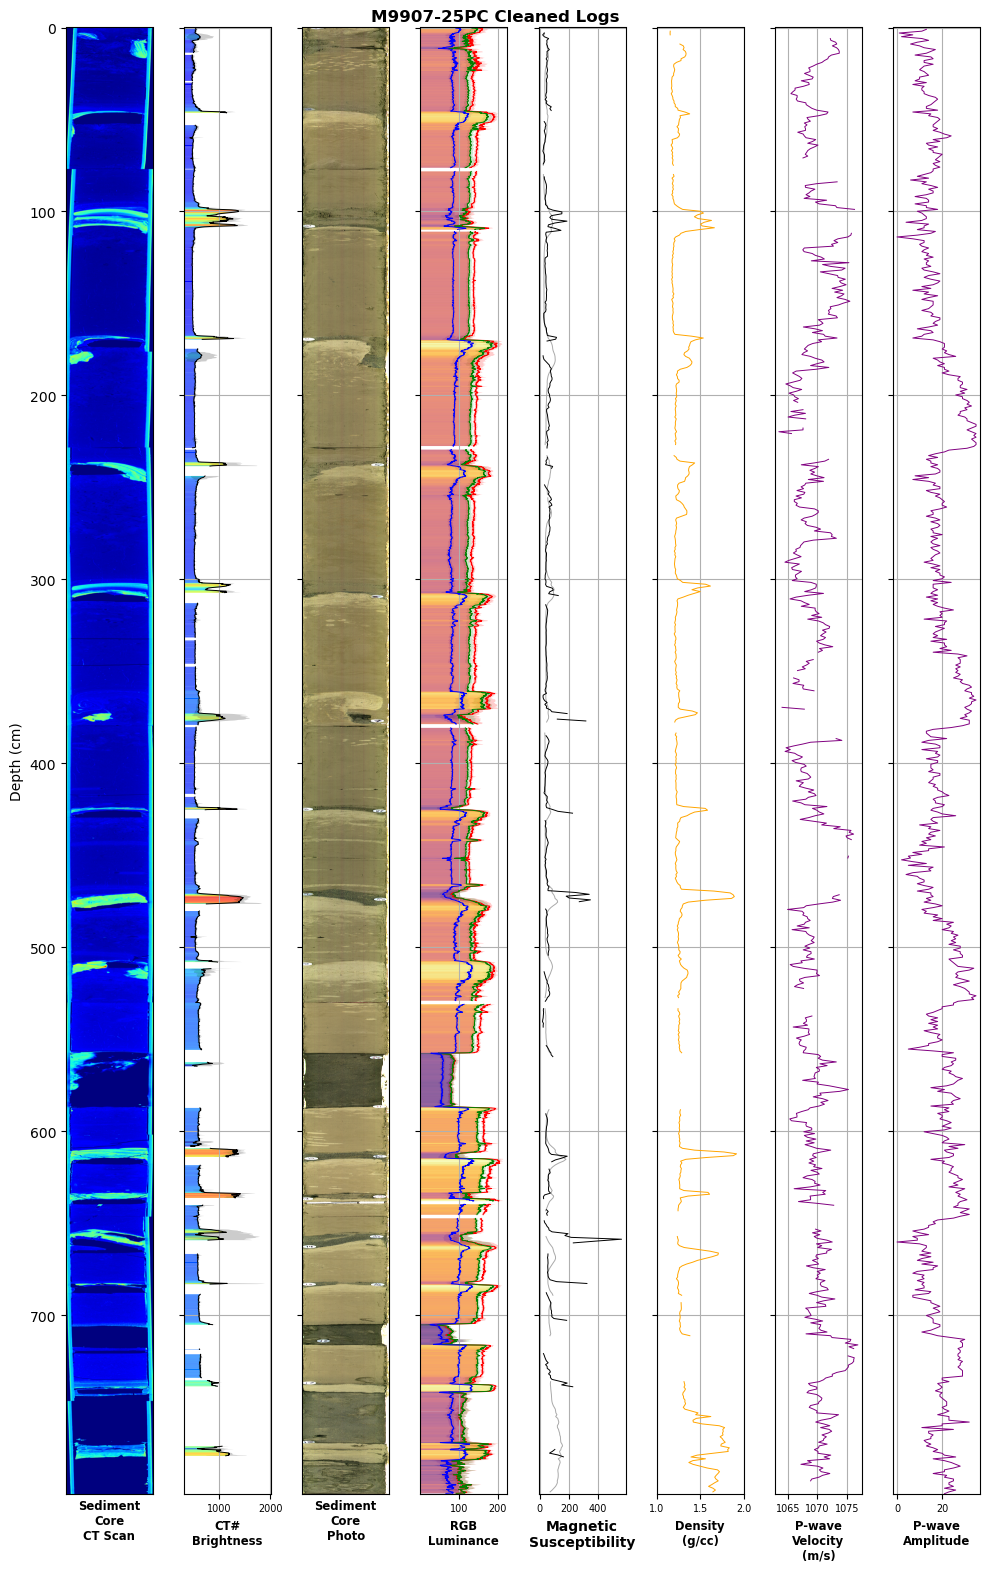

In [15]:
# Run data cleaning function
preprocess_core_data(data_config)

# Plot processed logs
plt_title = f'{core_name} Cleaned Logs'
fig, axes = plot_core_logs(clean_data_paths, column_configs, core_length, ct_img, rgb_img, title=plt_title)
plt.show()

### ML-based data gap filling

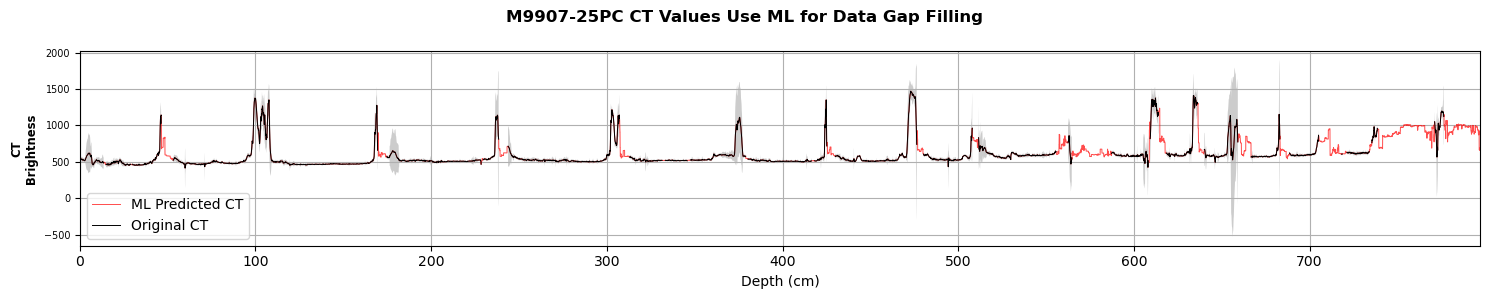

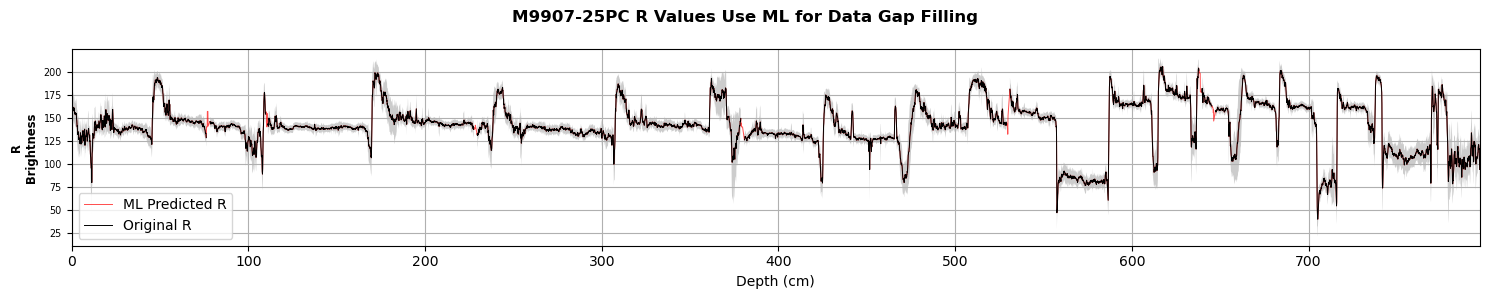

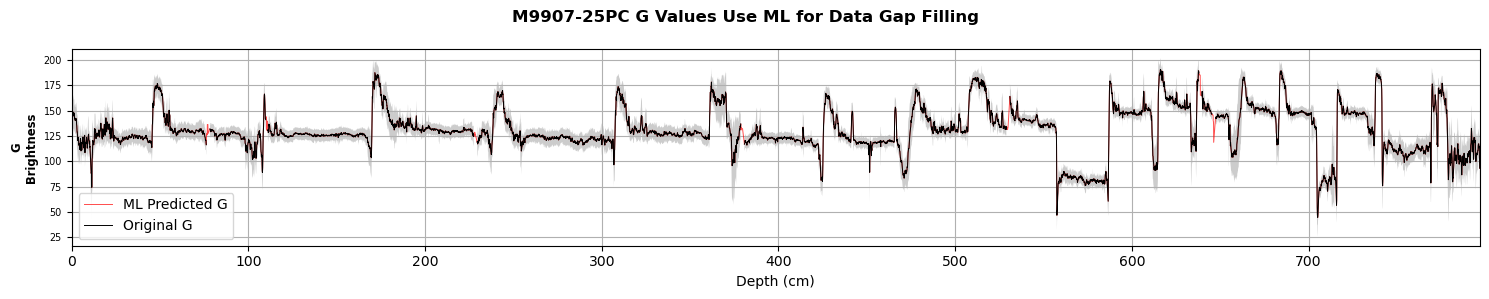

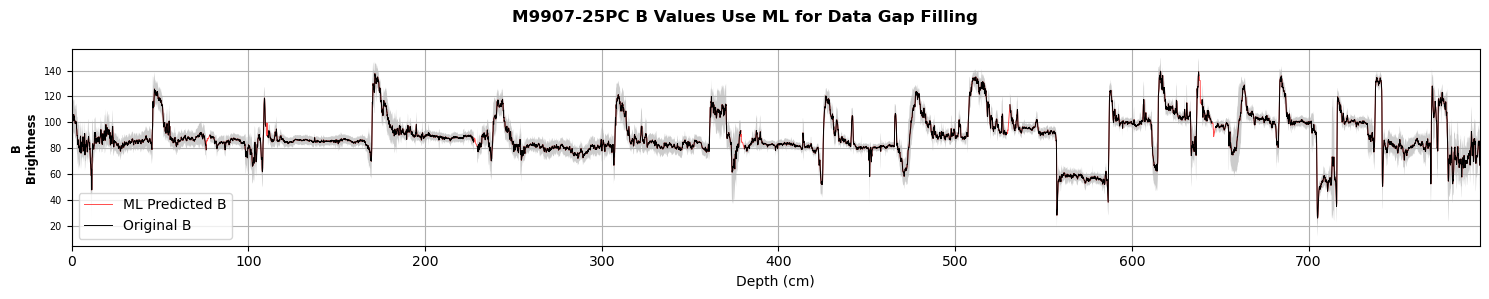

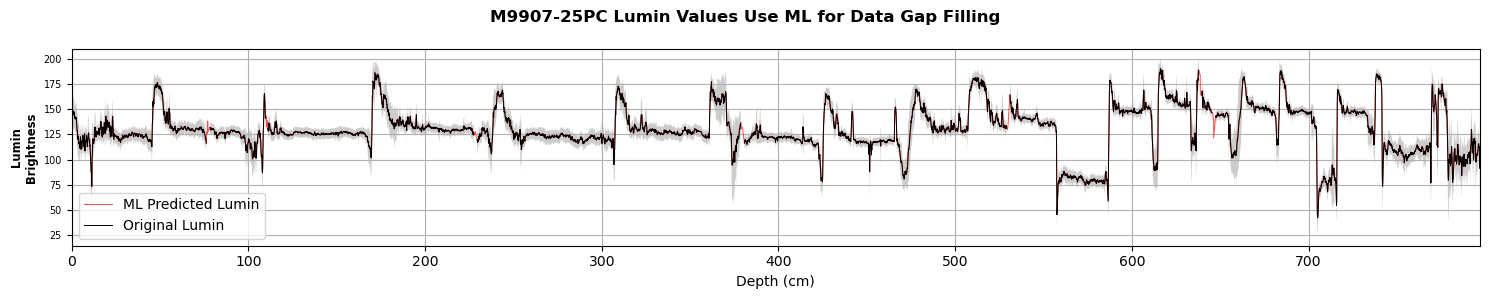

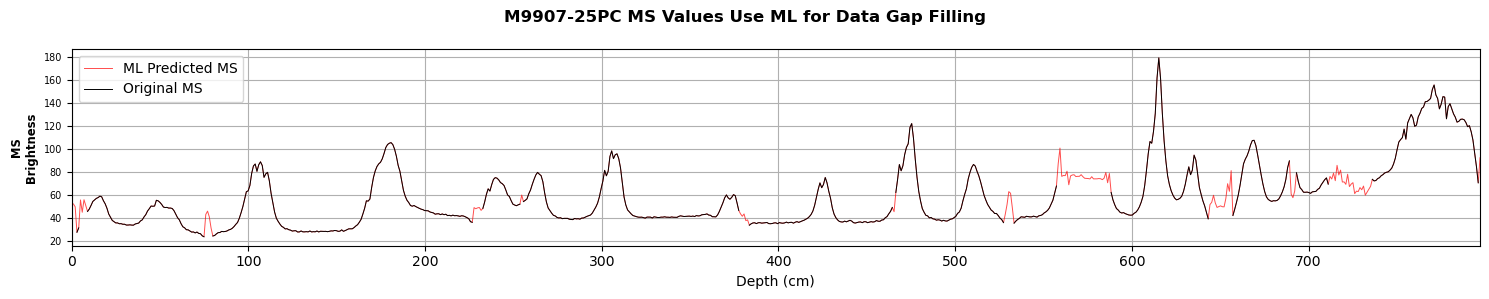

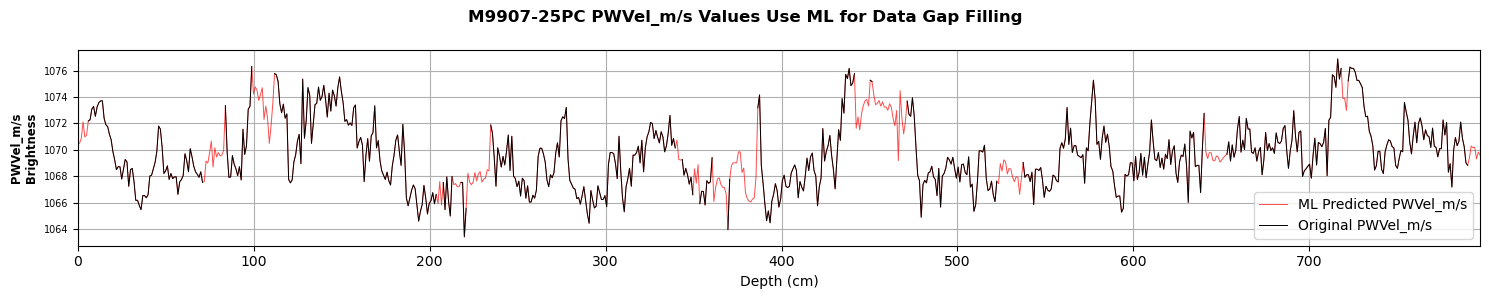

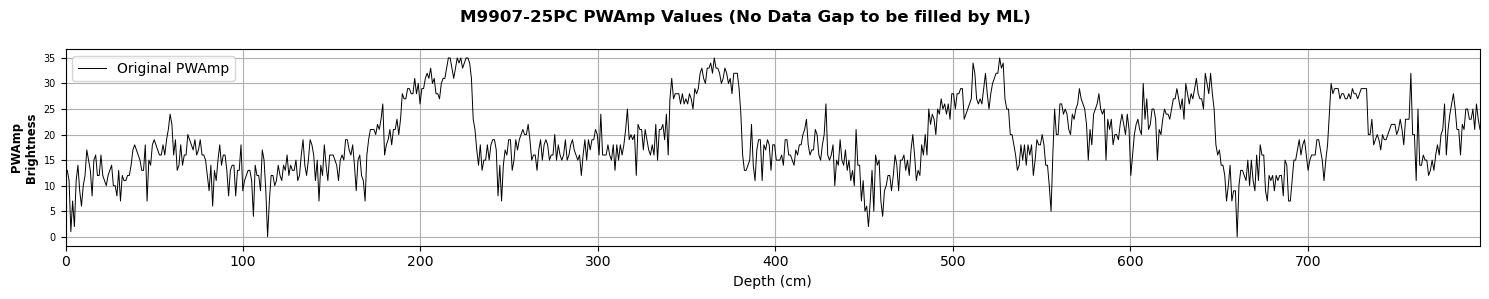

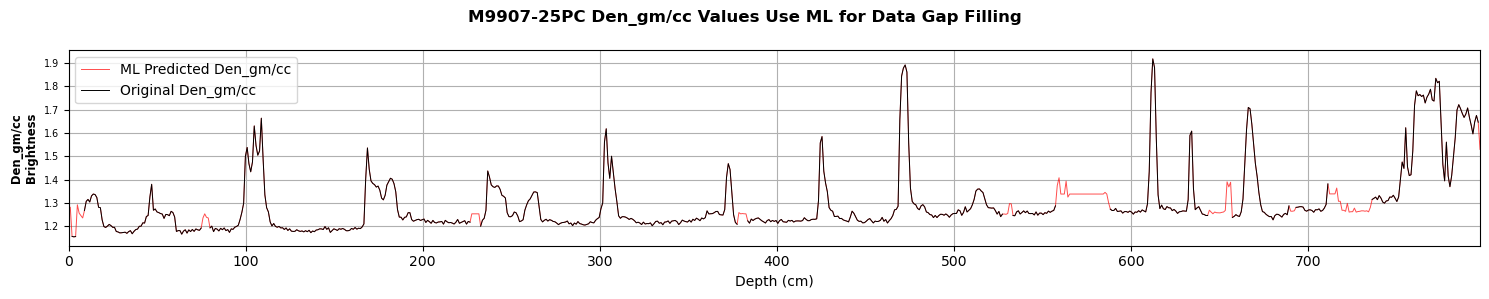

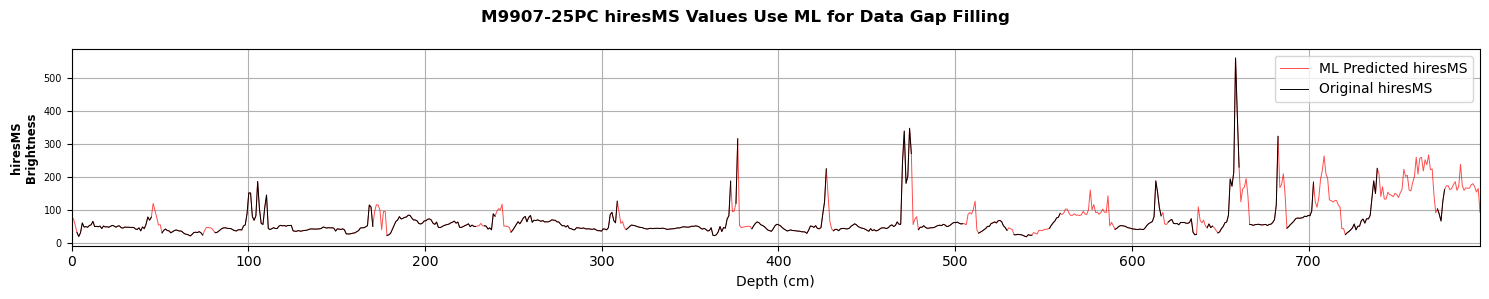

Filled data from M9907-25PC_R_MLfilled.csv has replaced the original R column
Filled data from M9907-25PC_G_MLfilled.csv has replaced the original G column
Filled data from M9907-25PC_B_MLfilled.csv has replaced the original B column
Filled data from M9907-25PC_Lumin_MLfilled.csv has replaced the original Lumin column
Removed M9907-25PC_R_MLfilled.csv
Removed M9907-25PC_G_MLfilled.csv
Removed M9907-25PC_B_MLfilled.csv
Removed M9907-25PC_Lumin_MLfilled.csv
Filled data from M9907-25PC_Den_MLfilled.csv has replaced the original Den_gm/cc column
Filled data from M9907-25PC_PWVel_MLfilled.csv has replaced the original PWVel_m/s column
Filled data from M9907-25PC_PWAmp_MLfilled.csv has replaced the original PWAmp column
Filled data from M9907-25PC_MS_MLfilled.csv has replaced the original MS column
Removed M9907-25PC_Den_MLfilled.csv
Removed M9907-25PC_PWVel_MLfilled.csv
Removed M9907-25PC_PWAmp_MLfilled.csv
Removed M9907-25PC_MS_MLfilled.csv


In [16]:
# # Random Forest ML
# process_and_fill_logs(mother_dir=mother_dir, core_name=core_name, core_length=core_length,
#                       clean_output_folder=clean_output_folder, filled_output_folder=filled_output_folder, ml_method='rf')
# plt_title = f'{core_name} Random Forest ML Filled Logs'

# # Random Forest ML with trend constraints
# process_and_fill_logs(mother_dir=mother_dir, core_name=core_name, core_length=core_length,
#                       clean_output_folder=clean_output_folder, filled_output_folder=filled_output_folder, ml_method='rftc')
# plt_title = f'{core_name} Random Forest ML + Trend Constraint Filled Logs'

# # XGBoost ML
# process_and_fill_logs(mother_dir=mother_dir, core_name=core_name, core_length=core_length,
#                       clean_output_folder=clean_output_folder, filled_output_folder=filled_output_folder, ml_method='xgb')
# plt_title = f'{core_name} XGBoost ML-Filled Logs'

# XGBoost + LightGBM ML
process_and_fill_logs(mother_dir=mother_dir, core_name=core_name, core_length=core_length,
                      clean_output_folder=clean_output_folder, filled_output_folder=filled_output_folder, ml_method='xgblgbm')
plt_title = f'{core_name} XGBoost + LightGBM ML-Filled Logs'

#### Show ML-filed plot

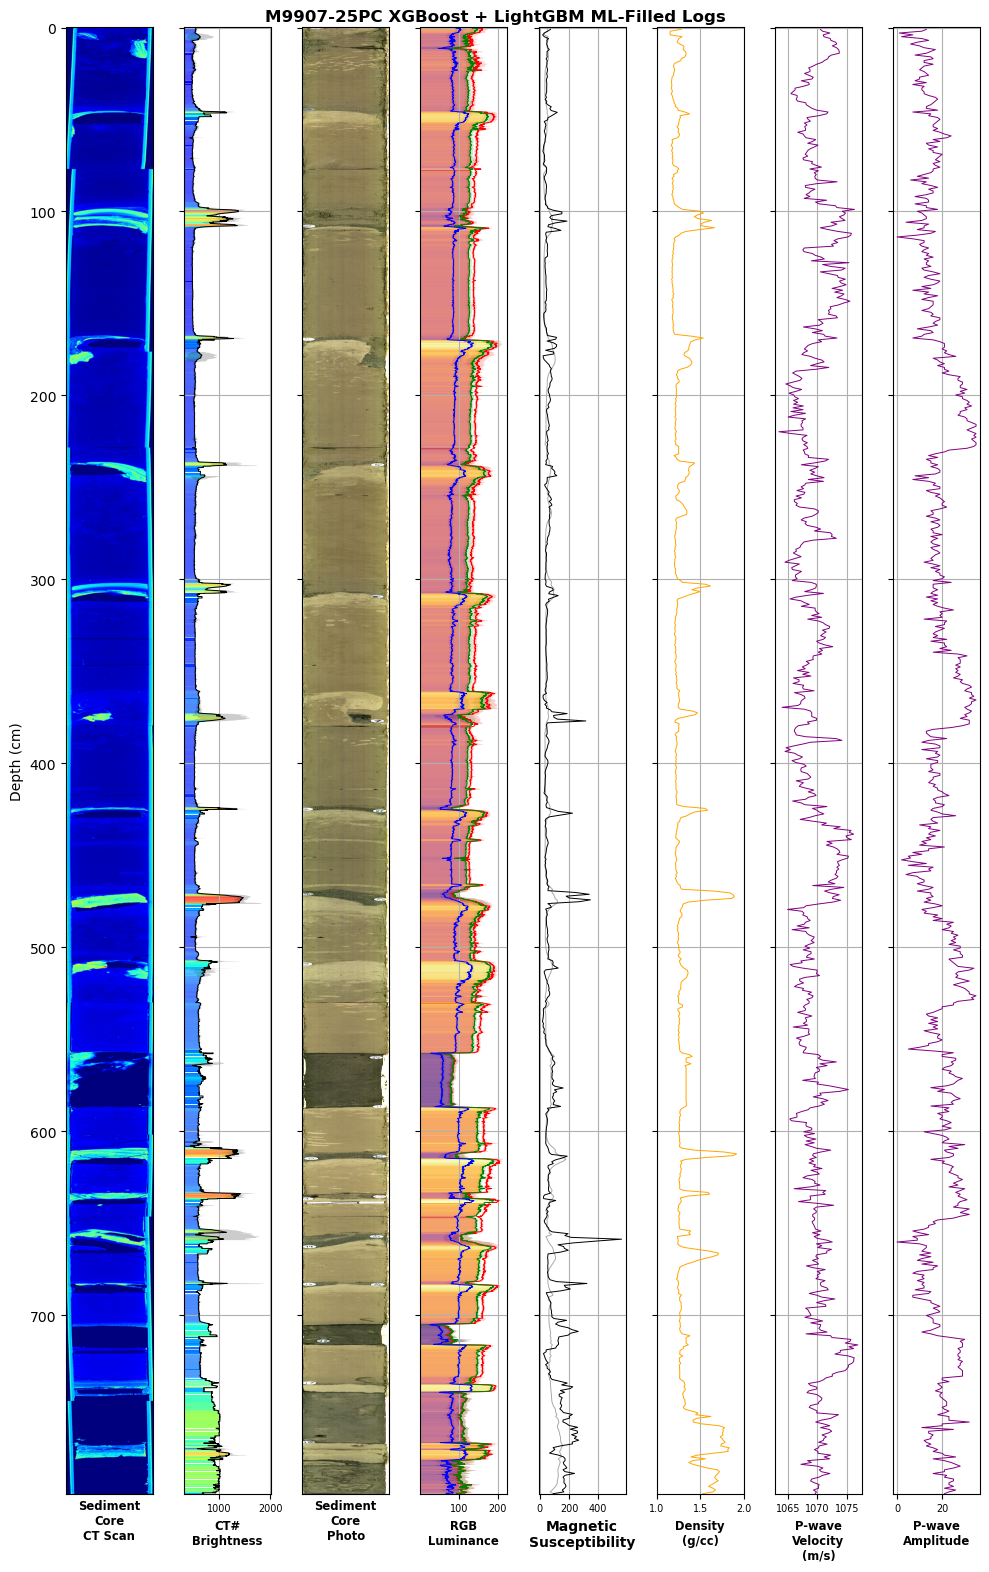

In [17]:
# Plot filled logs
fig, axes = plot_core_logs(filled_data_paths, column_configs, core_length, ct_img, rgb_img, title=plt_title)
plt.show()